# Visual Question Answering and Image Captioning using BLIP and OpenVINO

Humans perceive the world through vision and language. A longtime goal of AI is to build intelligent agents that can understand the world through vision and language inputs to communicate with humans through natural language. In order to achieve this goal, vision-language pre-training has emerged as an effective approach, where deep neural network models are pre-trained on large scale image-text datasets to improve performance on downstream vision-language tasks, such as image-text retrieval, image captioning, and visual question answering.

[BLIP](https://github.com/salesforce/BLIP) is a language-image pre-training framework for unified vision-language understanding and generation. BLIP achieves state-of-the-art results on a wide range of vision-language tasks. This tutorial demonstrates how to use BLIP for visual question answering and image captioning.

The tutorial consists of the following parts:

1. Instantiate a BLIP model.
2. Convert the BLIP model to OpenVINO IR.
3. Run visual question answering and image captioning with OpenVINO.


### Table of content:
- [Background](#Background-Uparrow)
    - [Image Captioning](#Image-Captioning-Uparrow)
    - [Visual Question Answering](#Visual-Question-Answering-Uparrow)
- [Instantiate Model](#Instantiate-Model-Uparrow)
- [Convert Models to OpenVINO IR](#Convert-Models-to-OpenVINO-IR-Uparrow)
    - [Vision Model](#Vision-Model-Uparrow)
    - [Text Encoder](#Text-Encoder-Uparrow)
    - [Text Decoder](#Text-Decoder-Uparrow)
- [Run OpenVINO Model](#Run-OpenVINO-Model-Uparrow)
    - [Prepare Inference Pipeline](#Prepare-Inference-Pipeline-Uparrow)
    - [Select inference device](#Select-inference-device-Uparrow)
    - [Image Captioning](#Image-Captioning-Uparrow)
    - [Question Answering](#Question-Answering-Uparrow)

## Background [$\Uparrow$](#Table-of-content:)

Visual language processing is a branch of artificial intelligence that focuses on creating algorithms designed to enable computers to more accurately understand images and their content.

Popular tasks include:

* **Text to Image Retrieval** - a semantic task that aims to find the most relevant image for a given text description.
* **Image Captioning** - a semantic task that aims to provide a text description for image content.
* **Visual Question Answering** - a semantic task that aims to answer questions based on image content.

As shown in the diagram below, these three tasks differ in the input provided to the AI system. For text-to-image retrieval, you have a predefined gallery of images for search and a user-requested text description (query). Image captioning can be represented as a particular case of visual question answering, where you have a predefined question "What is in the picture?" and various images provided by a user. For visual question answering, both the text-based question and image context are variables requested by a user.

![](https://user-images.githubusercontent.com/29454499/221755717-a5b51b7e-523c-461f-b30c-4edbfaf9a134.png)

This notebook does not focus on Text to Image retrieval. Instead, it considers Image Captioning and Visual Question Answering.

### Image Captioning [$\Uparrow$](#Table-of-content:)

Image Captioning is the task of describing the content of an image in words. This task lies at the intersection of computer vision and natural language processing. Most image captioning systems use an encoder-decoder framework, where an input image is encoded into an intermediate representation of the information in the image, and then decoded into a descriptive text sequence.

![](https://user-images.githubusercontent.com/29454499/221640847-1868117c-aac0-4806-99a4-34f218e98bb8.png)

### Visual Question Answering [$\Uparrow$](#Table-of-content:)
Visual Question Answering (VQA) is the task of answering text-based questions about image content.

![](https://user-images.githubusercontent.com/29454499/221641984-3c6d8b2f-dd0d-4302-a4d8-0f8564fca772.png)

For a better understanding of how VQA works, let us consider a traditional NLP task like Question Answering, which aims to retrieve the answer to a question from a given text input. Typically, a question answering pipeline consists of three steps:

![](https://user-images.githubusercontent.com/29454499/221760881-378f1ea8-eadc-4610-aff0-69ecabf62fff.png)

1. Question analysis - analysis of provided question in natural language form to understand the object in the question and additional context. For example, if you have a question like "How many bridges in Paris?", question words *"how many"* gives a hint that the answer is more likely to be a number, *"bridges"* is the target object of the question and *" in Paris"* serves as additional context for the search.
2. Build query for search - use analyzed results to formalize query for finding the most relevant information.
3. Perform a search in the knowledge base - send the query to a knowledge base, typically provided text documents or databases serve as a source of knowledge.

![](https://user-images.githubusercontent.com/29454499/222094861-3cafdf9f-d700-4741-b6c5-fb09c1a4da9a.png)

The difference between text-based question answering and visual question answering is that an image is used as context and the knowledge base.

![](https://user-images.githubusercontent.com/29454499/222095118-3d5826e4-2662-4d1c-abf2-a515f23d6d6a.png)

Answering arbitrary questions about images is a complex problem because it requires involving a lot of computer vision sub-tasks. In the table below, you can find an example of questions and the required computer vision skills to find answers.

| Computer vision task                   | Question examples                                       |
|----------------------------------------| ------------------------------------------------------- |
| Object recognition                     | What is shown in the picture? What is it?               |
| Object detection                       | Is there any object (dog, man, book) in the image? Where is … located? |
| Object and image attribute recognition | What color is an umbrella? Does this man wear glasses? Is there color in the image? |
| Scene recognition                      | Is it rainy? What celebration is pictured? |
| Object counting                        | How many players are there on the football field? How many steps are there on the stairs? |
| Activity recognition                   | Is the baby crying? What is the woman cooking? What are they doing?                       |
| Spatial relationships among objects    | What is located between the sofa and the armchair? What is in the bottom left corner? |
| Commonsense reasoning                  | Does she have 100% vision? Does this person have children? |
| Knowledge-based reasoning              | Is it a vegetarian pizza? |
| Text recognition                       | What is the title of the book? What is shown on the screen? |


There are a lot of applications for visual question answering:

* Aid Visually Impaired Persons: VQA models can be used to reduce barriers for visually impaired people by helping them get information about images from the web and the real world.
* Education: VQA models can be used to improve visitor experiences at museums by enabling observers to directly ask questions they are interested in or to bring more interactivity to schoolbooks for children interested in acquiring specific knowledge.
* E-commerce: VQA models can retrieve information about products using photos from online stores.
* Independent expert assessment: VQA models can be provide objective assessments in sports competitions, medical diagnosis, and forensic examination.

## Instantiate Model [$\Uparrow$](#Table-of-content:)

The BLIP model was proposed in the [BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation](https://arxiv.org/abs/2201.12086) paper.

![blip.gif](https://github.com/salesforce/BLIP/raw/main/BLIP.gif)

To pre-train a unified vision-language model with both understanding and generation capabilities, BLIP introduces a multimodal mixture of an encoder-decoder and a multi-task model which can operate in one of the three modes:

* **Unimodal encoders**, which separately encode images and text. The image encoder is a vision transformer. The text encoder is the same as BERT.
* **Image-grounded text encoder**, which injects visual information by inserting a cross-attention layer between the self-attention layer and the feed-forward network for each transformer block of the text encoder.
* **Image-grounded text decoder**, which replaces the bi-directional self-attention layers in the text encoder with causal self-attention layers.

More details about the model can be found in the [research paper](https://arxiv.org/abs/2201.12086), [Salesforce blog](https://blog.salesforceairesearch.com/blip-bootstrapping-language-image-pretraining/), [GitHub repo](https://github.com/salesforce/BLIP) and [Hugging Face model documentation](https://huggingface.co/docs/transformers/model_doc/blip).

In this tutorial, you will use the [`blip-vqa-base`](https://huggingface.co/Salesforce/blip-vqa-base) model available for download from [Hugging Face](https://huggingface.co/). The same actions are also applicable to other similar models from the BLIP family. Although this model class is designed to perform question answering, its components can also be reused for image captioning.

To start working with the model, you need to instantiate the `BlipForQuestionAnswering` class, using `from_pretrained` method. `BlipProcessor` is a helper class for preparing input data for both text and vision modalities and postprocessing of generation results.

In [1]:
!pip install -q "transformers >= 4.26.0" gradio


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import sys
import time
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering

sys.path.append("../utils")
from notebook_utils import download_file

# get model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

# setup test input: download and read image, prepare question
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
download_file(img_url, "demo.jpg")
raw_image = Image.open("demo.jpg").convert('RGB')
question = "how many dogs are in the picture?"
# preprocess input data
inputs = processor(raw_image, question, return_tensors="pt")

start = time.perf_counter()
# perform generation
out = model.generate(**inputs)
end = time.perf_counter() - start

# postprocess result
answer = processor.decode(out[0], skip_special_tokens=True)

demo.jpg:   0%|          | 0.00/485k [00:00<?, ?B/s]

/home/adrian/repos/openvino_notebooks_adrian/venv/lib/python3.9/site-packages/transformers/generation/utils.py:1254: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [3]:
print(f"Processing time: {end:.4f} s")

Processing time: 0.3268 s


In [4]:
import matplotlib.pyplot as plt
import PIL
import numpy as np


def visualize_results(orig_img:PIL.Image.Image, answer:str, question:str = None):
    """
    Helper function for results visualization
    
    Parameters:
       orig_img (PIL.Image.Image): original image
       answer (str): model answer in text format.
       question (str, *optional*, None): input question, if not provided answer will be used as caption
    Returns:
       fig (matplotlib.pyplot.Figure): matplotlib generated figure contains drawing result
    """
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    ax = fig.add_subplot(111)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.grid(False)
    ax.imshow(np.array(orig_img))
    qa_text = "question: {}\nanswer: {}"
    cap_text = "caption: {}"
    ax.set_title(qa_text.format(question, answer) if question is not None else cap_text.format(answer), y=-0.01, pad=-30 if question is not None else -15)
    return fig

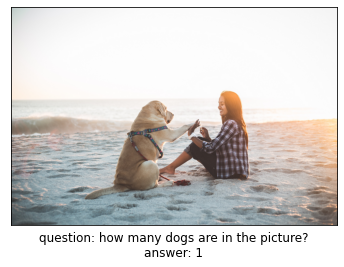

In [5]:
fig = visualize_results(raw_image, answer, question)

## Convert Models to OpenVINO IR [$\Uparrow$](#Table-of-content:)

OpenVINO supports PyTorch through export to the ONNX format. You will use the `torch.onnx.export` function for obtaining ONNX model. For more information, refer to to the [PyTorch documentation](https://pytorch.org/docs/stable/onnx.html). You need to provide a model object, input data for model tracing, and a path for saving the model. Optionally, you can provide a target onnx opset for conversion and other parameters specified in the documentation (for example, input and output names or dynamic shapes).

While ONNX models are directly supported by OpenVINO™ runtime, it can be useful to convert them to OpenVINO Intermediate Representation (IR) format to take the advantage of advanced OpenVINO optimization tools and features. You will use model conversion API to convert the model to IR format and compress weights to `FP16` format.

The model consists of three parts:

* vision_model - an encoder for image representation.
* text_encoder - an encoder for input query, used for question answering and text-to-image retrieval only.
* text_decoder - a decoder for output answer.

To be able to perform multiple tasks, using the same model components, you should convert each part independently.

### Vision Model [$\Uparrow$](#Table-of-content:)

The vision model accepts float input tensors with the [1,3,384,384] shape, containing RGB image pixel values normalized in the [0,1] range.

In [6]:
import torch
from pathlib import Path
from openvino.tools import mo
from openvino.runtime import Core, serialize

VISION_MODEL_OV = Path("blip_vision_model.xml")
VISION_MODEL_ONNX = VISION_MODEL_OV.with_suffix(".onnx")
vision_model = model.vision_model
vision_model.eval()

# check that model works and save it outputs for reusage as text encoder input
with torch.no_grad():
    vision_outputs = vision_model(inputs["pixel_values"])

# if openvino model does not exist, convert it to onnx and then to IR
if not VISION_MODEL_OV.exists():
    
    # export pytorch model to ONNX
    if not VISION_MODEL_ONNX.exists():
        with torch.no_grad():
            torch.onnx.export(vision_model, inputs["pixel_values"], VISION_MODEL_ONNX, input_names=["pixel_values"])
    # convert ONNX model to IR using model conversion Python API, use compress_to_fp16=True for compressing model weights to FP16 precision        
    ov_vision_model = mo.convert_model(VISION_MODEL_ONNX, compress_to_fp16=True)
    # save model on disk for next usages
    serialize(ov_vision_model, str(VISION_MODEL_OV))
    print(f"Vision model successfuly converted and saved to {VISION_MODEL_OV}")
else:
    print(f"Vision model will be loaded from {VISION_MODEL_OV}")

Vision model successfuly converted and saved to blip_vision_model.xml


### Text Encoder [$\Uparrow$](#Table-of-content:)

The text encoder is used by visual question answering tasks to build a question embedding representation. It takes `input_ids` with a tokenized question and output image embeddings obtained from the vision model and attention masks for them.

The number of tokens after tokenizing input can be different depending on the question text. You should preserve dynamic shapes for model inputs working with tokens, the `dynamic_axes` parameter is responsible for preserving dynamic specific dimensions of inputs in `torch.onnx.export`. For consistency in mapping between dynamic axes and inputs, the `input_names` is parameter provided. For more information about how these export parameters work, see the [PyTorch tutorial](https://pytorch.org/tutorials/advanced/super_resolution_with_onnxruntime.html)

In [7]:
TEXT_ENCODER_OV = Path("blip_text_encoder.xml")
TEXT_ENCODER_ONNX = TEXT_ENCODER_OV.with_suffix(".onnx")

text_encoder = model.text_encoder
text_encoder.eval()

# if openvino model does not exist, convert it to onnx and then to IR
if not TEXT_ENCODER_OV.exists():
    if not TEXT_ENCODER_ONNX.exists():
        # prepare example inputs for ONNX export
        image_embeds = vision_outputs[0]
        image_attention_mask = torch.ones(image_embeds.size()[:-1], dtype=torch.long)
        input_dict = {"input_ids": inputs["input_ids"], "attention_mask": inputs["attention_mask"], "encoder_hidden_states": image_embeds, "encoder_attention_mask": image_attention_mask}
        # specify variable length axes
        dynamic_axes = {"input_ids": {1: "seq_len"}, "attention_mask": {1: "seq_len"}}
        # export PyTorch model to ONNX
        with torch.no_grad():
            torch.onnx.export(text_encoder, input_dict, TEXT_ENCODER_ONNX, input_names=list(input_dict), dynamic_axes=dynamic_axes)
    # convert ONNX model to IR using model conversion Python API, use compress_to_fp16=True for compressing model weights to FP16 precision
    ov_text_encoder = mo.convert_model(TEXT_ENCODER_ONNX, compress_to_fp16=True)
    # save model on disk for next usages
    serialize(ov_text_encoder, str(TEXT_ENCODER_OV))
    print(f"Text encoder successfuly converted and saved to {TEXT_ENCODER_OV}")
else:
    print(f"Text encoder will be loaded from {TEXT_ENCODER_OV}")

/home/adrian/repos/openvino_notebooks_adrian/venv/lib/python3.9/site-packages/transformers/models/blip/modeling_blip_text.py:712: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if is_decoder:
/home/adrian/repos/openvino_notebooks_adrian/venv/lib/python3.9/site-packages/transformers/models/blip/modeling_blip_text.py:631: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if is_decoder:


Text encoder successfuly converted and saved to blip_text_encoder.xml


### Text Decoder [$\Uparrow$](#Table-of-content:)

The text decoder is responsible for generating the sequence of tokens to represent model output (answer to question or caption), using an image (and question, if required) representation. The generation approach is based on the assumption that the probability distribution of a word sequence can be decomposed into the product of conditional next word distributions. In other words, model predicts the next token in the loop guided by previously generated tokens until the stop-condition will be not reached (generated sequence of maximum length or end of string token obtained). The way the next token will be selected over predicted probabilities is driven by the selected decoding methodology. You can find more information about the most popular decoding methods in this [blog](https://huggingface.co/blog/how-to-generate). The entry point for the generation process for models from the Hugging Face Transformers library is the `generate` method. You can find more information about its parameters and configuration in the[documentation](https://huggingface.co/docs/transformers/v4.26.1/en/main_classes/text_generation#transformers.GenerationMixin.generate). To preserve flexibility in the selection decoding methodology, you will convert only model inference for one step.

To optimize the generation process and use memory more efficiently, the `use_cache=True` option is enabled. Since the output side is auto-regressive, an output token hidden state remains the same once computed for every further generation step. Therefore, recomputing it every time you want to generate a new token seems wasteful. With the cache, the model saves the hidden state once it has been computed. The model only computes the one for the most recently generated output token at each time step, re-using the saved ones for hidden tokens. This reduces the generation complexity from O(n^3) to O(n^2) for a transformer model. More details about how it works can be found in this [article](https://scale.com/blog/pytorch-improvements#Text%20Translation). With this option, the model gets the previous step's hidden states as input and additionally provides hidden states for the current step as output. Initially, you have no previous step hidden states, so the first step does not require you to provide them. ONNX export prevents a variable number of inputs in the model, which means that you should handle the first step as a separate model. `blip_text_decoder` will be used for the first step generation, and `blip_text_decoder_with_past` for the next steps.
The first step model has hidden state representation outputs. In PyTorch, they are represented as a list of pairs (hidden state for key, hidden state for value] for each transformer layer in the model. ONNX model does not support nested outputs, they will be flattened. For preserving corresponding between hidden state keys and layers `output_names` parameter for ONNX export.

Similar to `text_encoder`, `text_decoder` can work with input sequences of different lengths and requires preserving dynamic input shapes.

In [8]:
text_decoder = model.text_decoder
text_decoder.eval()

TEXT_DECODER_OV = Path("blip_text_decoder.xml")
TEXT_DECODER_ONNX = TEXT_DECODER_OV.with_suffix(".onnx")

# prepare example inputs for ONNX export
input_ids = torch.tensor([[30522]])  # begin of sequence token id
attention_mask = torch.tensor([[1]])  # attention mask for input_ids
encoder_hidden_states = torch.rand((1, 10, 768))  # encoder last hidden state from text_encoder
encoder_attention_mask = torch.ones((1, 10), dtype=torch.long)  # attention mask for encoder hidden states

input_dict = {"input_ids": input_ids, "attention_mask": attention_mask, "encoder_hidden_states": encoder_hidden_states, "encoder_attention_mask": encoder_attention_mask}
# specify variable length axes
dynamic_axes = {"input_ids": {1: "seq_len"}, "attention_mask": {1: "seq_len"}, "encoder_hidden_states": {1: "enc_seq_len"}, "encoder_attention_mask": {1: "enc_seq_len"}}

# specify output names, logits is main output of model
output_names = ["logits"]

# past key values outputs are output for caching model hidden state
past_key_values_outs = []
text_decoder_outs = text_decoder(**input_dict)
for idx, _ in enumerate(text_decoder_outs["past_key_values"]):
    past_key_values_outs.extend([f"out_past_key_value.{idx}.key", f"out_past_key_value.{idx}.value"])

# if openvino model does not exist, convert it to onnx and then to IR
if not TEXT_DECODER_OV.exists():
    # export PyTorch model to ONNX
    if not TEXT_DECODER_ONNX.exists():
        with torch.no_grad():
            torch.onnx.export(text_decoder, input_dict, TEXT_DECODER_ONNX, input_names=list(input_dict), output_names=output_names + past_key_values_outs, dynamic_axes=dynamic_axes)
    # convert ONNX model to IR using model conversion Python API, use compress_to_fp16=True for compressing model weights to FP16 precision
    ov_text_decoder = mo.convert_model(TEXT_DECODER_ONNX, compress_to_fp16=True)
    # save model on disk for next usages
    serialize(ov_text_decoder, str(TEXT_DECODER_OV))
    print(f"Text decoder successfuly converted and saved to {TEXT_DECODER_OV}")
else:
    print(f"Text decoder will be loaded from {TEXT_DECODER_OV}")

/home/adrian/repos/openvino_notebooks_adrian/venv/lib/python3.9/site-packages/transformers/models/blip/modeling_blip_text.py:640: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if causal_mask.shape[1] < attention_mask.shape[1]:
/home/adrian/repos/openvino_notebooks_adrian/venv/lib/python3.9/site-packages/transformers/models/blip/modeling_blip_text.py:889: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if return_logits:


Text decoder successfuly converted and saved to blip_text_decoder.xml


For the text decoder in the following steps, there are also additional inputs for hidden states from the previous step. Similar to the outputs, they will be flattened after the model is exported to ONNX format. You need to update `dynamic_axes` and `input_names` with new input layers.

In [9]:
# extend input dictionary with hidden states from previous step
input_dict_with_past = {**input_dict, "past_key_values": text_decoder_outs["past_key_values"]}

# provide names for past_key_value inputs in ONNX model
past_inputs = [k.replace("out_", "in_") for k in past_key_values_outs]

# extend input names list and dynamic axes with new inputs
input_names_with_past = list(input_dict) + past_inputs
dynamic_axes_with_past = {**dynamic_axes}
for k in past_inputs:
    dynamic_axes_with_past[k] = {2: "prev_seq_len"}

TEXT_DECODER_WITH_PAST_OV = Path("blip_text_decoder_with_past.xml")
TEXT_DECODER_WITH_PAST_ONNX = TEXT_DECODER_WITH_PAST_OV.with_suffix(".onnx")

# if openvino model does not exist, convert it to onnx and then to IR
if not TEXT_DECODER_WITH_PAST_OV.exists():
    # export PyTorch model to ONNX
    if not TEXT_DECODER_WITH_PAST_ONNX.exists():
        with torch.no_grad():
            torch.onnx.export(text_decoder, input_dict_with_past, TEXT_DECODER_WITH_PAST_ONNX, input_names=input_names_with_past, output_names=output_names + past_key_values_outs, dynamic_axes=dynamic_axes_with_past)
    # convert ONNX model to IR using model conversion Python API, use compress_to_fp16=True for compressing model weights to FP16 precision
    ov_text_decoder = mo.convert_model(TEXT_DECODER_WITH_PAST_ONNX, compress_to_fp16=True)
    # save model on disk for next usages
    serialize(ov_text_decoder, str(TEXT_DECODER_WITH_PAST_OV))
    print(f"Text decoder with past successfuly converted and saved to {TEXT_DECODER_WITH_PAST_OV}")
else:
    print(f"Text decoder with past will be loaded from {TEXT_DECODER_WITH_PAST_OV}")

Text decoder with past successfuly converted and saved to blip_text_decoder_with_past.xml


## Run OpenVINO Model [$\Uparrow$](#Table-of-content:)

### Prepare Inference Pipeline [$\Uparrow$](#Table-of-content:)

As discussed before, the model consists of several blocks which can be reused for building pipelines for different tasks. In the diagram below, you can see how image captioning works:

![](https://user-images.githubusercontent.com/29454499/221865836-a56da06e-196d-449c-a5dc-4136da6ab5d5.png)


The visual model accepts the image preprocessed by `BlipProcessor` as input and produces image embeddings, which are directly passed to the text decoder for generation caption tokens. When generation is finished, output sequence of tokens is provided to `BlipProcessor` for decoding to text using a tokenizer.

The pipeline for question answering looks similar, but with additional question processing. In this case, image embeddings and question tokenized by `BlipProcessor` are provided to the text encoder and then multimodal question embedding is passed to the text decoder for performing generation of answers.

![](https://user-images.githubusercontent.com/29454499/221868167-d0081add-d9f3-4591-80e7-4753c88c1d0a.png)

The next step is implementing both pipelines using OpenVINO models.

In [10]:
# create OpenVINO Core object instance
core = Core()

### Select inference device [$\Uparrow$](#Table-of-content:)

select device from dropdown list for running inference using OpenVINO

In [11]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='AUTO',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

In [12]:
# load models on device
ov_vision_model = core.compile_model(VISION_MODEL_OV, device.value)
ov_text_encoder = core.compile_model(TEXT_ENCODER_OV, device.value)
ov_text_decoder = core.compile_model(TEXT_DECODER_OV, device.value)
ov_text_decoder_with_past = core.compile_model(TEXT_DECODER_WITH_PAST_OV, device.value)

In [13]:
from typing import List, Tuple, Dict
from transformers.modeling_outputs import CausalLMOutputWithCrossAttentions


def prepare_past_inputs(past_key_values:List[Tuple[torch.Tensor, torch.Tensor]]):
    """
    Helper function for rearrange input hidden states inputs to OpenVINO model expected format
    Parameters:
      past_key_values (List[Tuple[torch.Tensor, torch.Tensor]]): list of pairs key, value attention hidden states obtained as model outputs from previous step
    Returns:
      inputs (Dict[str, torch.Tensor]): dictionary with inputs for model
    """
    inputs = {}
    for idx, (key, value) in enumerate(past_key_values):
        inputs[f"in_past_key_value.{idx}.key"] = key
        inputs[f"in_past_key_value.{idx}.value"] = value
    return inputs


def postprocess_text_decoder_outputs(output:Dict):
    """
    Helper function for rearranging model outputs and wrapping to CausalLMOutputWithCrossAttentions
    Parameters:
      output (Dict): dictionary with model output
    Returns
      wrapped_outputs (CausalLMOutputWithCrossAttentions): outputs wrapped to CausalLMOutputWithCrossAttentions format
    """
    outs = {k.any_name: v for k, v in output.items()}
    logits = torch.from_numpy(outs["logits"])
    past_kv = []
    for i in range(0, len(past_key_values_outs), 2):
        key = past_key_values_outs[i]
        value = key.replace(".key", ".value")
        past_kv.append((torch.from_numpy(outs[key]), torch.from_numpy(outs[value])))
    return CausalLMOutputWithCrossAttentions(
        loss=None,
        logits=logits,
        past_key_values=past_kv,
        hidden_states=None,
        attentions=None,
        cross_attentions=None
    )


def text_decoder_forward(input_ids:torch.Tensor, attention_mask:torch.Tensor, past_key_values:List[Tuple[torch.Tensor, torch.Tensor]], encoder_hidden_states:torch.Tensor, encoder_attention_mask:torch.Tensor, **kwargs):
    """
    Inference function for text_decoder in one generation step
    Parameters:
      input_ids (torch.Tensor): input token ids
      attention_mask (torch.Tensor): attention mask for input token ids
      past_key_values (List[Tuple[torch.Tensor, torch.Tensor]]): list of cached decoder hidden states from previous step
      encoder_hidden_states (torch.Tensor): encoder (vision or text) hidden states
      encoder_attention_mask (torch.Tensor): attnetion mask for encoder hidden states
    Returns
      model outputs (CausalLMOutputWithCrossAttentions): model prediction wrapped to CausalLMOutputWithCrossAttentions class including predicted logits and hidden states for caching
    """
    input_dict = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "encoder_hidden_states": encoder_hidden_states,
        "encoder_attention_mask": encoder_attention_mask
    }
    if past_key_values is None:
        outputs = ov_text_decoder(input_dict)
    else:
        input_dict.update(prepare_past_inputs(past_key_values))
        outputs = ov_text_decoder_with_past(input_dict)
    return postprocess_text_decoder_outputs(outputs)

        
text_decoder.forward = text_decoder_forward


class OVBlipModel:
    """ 
    Model class for inference BLIP model with OpenVINO
    """
    def __init__(self, config, decoder_start_token_id:int, vision_model, text_encoder, text_decoder):
        """
        Initialization class parameters
        """
        self.vision_model = vision_model
        self.vision_model_out = vision_model.output(0)
        self.text_encoder = text_encoder
        self.text_encoder_out = text_encoder.output(0)
        self.text_decoder = text_decoder
        self.config = config
        self.decoder_start_token_id = decoder_start_token_id
        self.decoder_input_ids = config.text_config.bos_token_id

    def generate_answer(self, pixel_values:torch.Tensor, input_ids:torch.Tensor, attention_mask:torch.Tensor, **generate_kwargs):
        """
        Visual Question Answering prediction
        Parameters:
          pixel_values (torch.Tensor): preprocessed image pixel values
          input_ids (torch.Tensor): question token ids after tokenization
          attention_mask (torch.Tensor): attention mask for question tokens
        Retruns:
          generation output (torch.Tensor): tensor which represents sequence of generated answer token ids
        """
        image_embed = self.vision_model(pixel_values.detach().numpy())[self.vision_model_out]
        image_attention_mask = np.ones(image_embed.shape[:-1], dtype=int)
        if isinstance(input_ids, list):
            input_ids = torch.LongTensor(input_ids)
        question_embeds = self.text_encoder([input_ids.detach().numpy(), attention_mask.detach().numpy(), image_embed, image_attention_mask])[self.text_encoder_out]
        question_attention_mask = np.ones(question_embeds.shape[:-1], dtype=int)

        bos_ids = np.full((question_embeds.shape[0], 1), fill_value=self.decoder_start_token_id)

        outputs = self.text_decoder.generate(
            input_ids=torch.from_numpy(bos_ids),
            eos_token_id=self.config.text_config.sep_token_id,
            pad_token_id=self.config.text_config.pad_token_id,
            encoder_hidden_states=torch.from_numpy(question_embeds),
            encoder_attention_mask=torch.from_numpy(question_attention_mask),
            **generate_kwargs,
        )
        return outputs                                                                                                                                                                                                    

    def generate_caption(self, pixel_values:torch.Tensor, input_ids:torch.Tensor = None, attention_mask:torch.Tensor = None, **generate_kwargs):
        """
        Image Captioning prediction
        Parameters:
          pixel_values (torch.Tensor): preprocessed image pixel values
          input_ids (torch.Tensor, *optional*, None): pregenerated caption token ids after tokenization, if provided caption generation continue provided text
          attention_mask (torch.Tensor): attention mask for caption tokens, used only if input_ids provided
        Retruns:
          generation output (torch.Tensor): tensor which represents sequence of generated caption token ids
        """
        batch_size = pixel_values.shape[0]

        image_embeds = self.vision_model(pixel_values.detach().numpy())[self.vision_model_out]

        image_attention_mask = torch.ones(image_embeds.shape[:-1], dtype=torch.long)

        if isinstance(input_ids, list):
            input_ids = torch.LongTensor(input_ids)
        elif input_ids is None:
            input_ids = (
                torch.LongTensor([[self.config.text_config.bos_token_id, self.config.text_config.eos_token_id]])
                .repeat(batch_size, 1)
            )
        input_ids[:, 0] = self.config.text_config.bos_token_id
        attention_mask = attention_mask[:, :-1] if attention_mask is not None else None

        outputs = self.text_decoder.generate(
            input_ids=input_ids[:, :-1],
            eos_token_id=self.config.text_config.sep_token_id,
            pad_token_id=self.config.text_config.pad_token_id,
            attention_mask=attention_mask,
            encoder_hidden_states=torch.from_numpy(image_embeds),
            encoder_attention_mask=image_attention_mask,
            **generate_kwargs,
        )

        return outputs

The model helper class has two methods for generation: **generate_answer** - used for visual question answering, **generate_caption** - used for caption generation.
For initialization, model class accepts compiled OpenVINO models for the text encoder, vision model and text decoder, and also configuration for generation and initial token for decoder work.

In [14]:
ov_model = OVBlipModel(model.config, model.decoder_start_token_id, ov_vision_model, ov_text_encoder, text_decoder)
out = ov_model.generate_answer(**inputs, max_length=20)

Now, the model is ready for generation.

### Image Captioning [$\Uparrow$](#Table-of-content:)


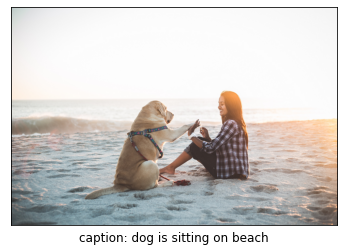

In [15]:
out = ov_model.generate_caption(inputs["pixel_values"], max_length=20)
caption = processor.decode(out[0], skip_special_tokens=True)
fig = visualize_results(raw_image, caption)

### Question Answering [$\Uparrow$](#Table-of-content:)


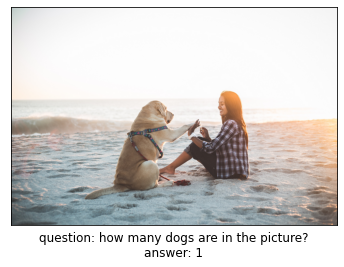

In [16]:
start = time.perf_counter()
out = ov_model.generate_answer(**inputs, max_length=20)
end = time.perf_counter() - start
answer = processor.decode(out[0], skip_special_tokens=True)
fig = visualize_results(raw_image, answer, question)

In [17]:
print(f"Processing time: {end:.4f}")

Processing time: 0.4076


## Interactive demo

In [ ]:
import gradio as gr


def generate_answer(img, question):
    if img is None:
        raise gr.Error("Please upload an image or choose one from the examples list")
    start = time.perf_counter()
    inputs = processor(img, question, return_tensors="pt")
    output = (
        ov_model.generate_answer(**inputs, max_length=20)
        if len(question)
        else ov_model.generate_caption(inputs["pixel_values"], max_length=20)
    )
    answer = processor.decode(output[0], skip_special_tokens=True)
    elapsed = time.perf_counter() - start
    html = f"<p>Processing time: {elapsed:.4f}</p>"
    return answer, html


demo = gr.Interface(
    generate_answer,
    [
        gr.Image(label="Image"),
        gr.Textbox(
            label="Question",
            info="If this field is empty, an image caption will be generated",
        ),
    ],
    [gr.Text(label="Answer"), gr.HTML()],
    examples=[["demo.jpg", ""], ["demo.jpg", question]],
)
try:
    demo.launch(debug=True)
except Exception:
    demo.launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/